In [2]:
import shap
import numpy as np
import pylab as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import *
import matplotlib
import xarray as xr
from scipy.io import loadmat

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-03-20 17:13:56.785272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 17:13:57.587808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# SHAP values

The following is based on work from

`Clare, M. C., Sonnewald, M., Lguensat, R., Deshayes, J., & Balaji, V. (2022). Explainable artificial intelligence for Bayesian neural networks: Toward trustworthy predictions of ocean dynamics. Journal of Advances in Modeling Earth Systems, 14(11), e2022MS003162.` 

which used a bayesian neural network to predict ocean regimes based on 8 physical features.

By subsampling this Bayesian Neural Network, we can generate a deep ensemble and to explain the skill of our deep ensemble neural network, we calculate the `SHAP` (SHapley Additive exPlanation) values. We calculate SHAP for an ensemble of deterministic neural networks which are trivially generated from the BNN.

The input features are 

    i) wind stress curl
    ii) bathymetry
    iii) sea level
    iv) coriolis force
    v) lat and lon gradient of bathymetry
    vi) lat and lon gradient of sea level

and we are predicting six different ocean regimes

Construct training dataset so that SHAP values can be calculated

In [3]:
monthlySSH = xr.open_mfdataset('xai_data/SSH.*.nc', combine='by_coords')
SSH20mean = monthlySSH['SSH'].mean(axis=0).values
Bathm = np.transpose(loadmat('xai_data/H_wHFacC.mat')['val'])
curlTau = np.transpose(np.load('xai_data/curlTau.npy'))
ecco_label = np.transpose(np.load('xai_data/kCluster6.npy'))
ecco_label[ecco_label==-1] = np.nan

lonRoll = np.roll(monthlySSH['lat'].values, axis=0, shift=-1)
Londiff = lonRoll - monthlySSH['lat'].values  # equivalent to doing x_{i} - x_{i-1}

lat = monthlySSH['lat'].values
latDiff=1.111774765625000e+05
latY=np.gradient(lat, axis=0)*latDiff
lonX=np.abs(np.cos(lat*np.pi/180))*latDiff*Londiff

Omega=7.2921e-5 # coriolis parameter
f = (2*Omega*np.sin(lat*np.pi/180))

def grad(d,y,x):
    grady=np.gradient(d, axis=0)/y
    gradx=np.gradient(d, axis=1)/x
    return grady, gradx

gradSSH_y, gradSSH_x = grad(SSH20mean,latY,lonX)
gradBathm_y, gradBathm_x = grad(Bathm,latY,lonX)

missingdataindex = np.isnan(curlTau*SSH20mean*gradSSH_x*gradSSH_y*Bathm*gradBathm_x*gradBathm_y)

maskTraining = (~missingdataindex).copy()
maskTraining[:,200:400]=False

maskVal = (~missingdataindex).copy()
maskVal[:,list(range(200))+list(range(400,720))]=False

TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Bathm[~missingdataindex],
                         gradBathm_x[~missingdataindex],
                         gradBathm_y[~missingdataindex],
                         f[~missingdataindex]),1)

TrainDataset = np.stack((curlTau[maskTraining],
                         SSH20mean[maskTraining],
                         gradSSH_x[maskTraining],
                         gradSSH_y[maskTraining],
                         Bathm[maskTraining],
                         gradBathm_x[maskTraining],
                         gradBathm_y[maskTraining],
                         f[maskTraining]),1)

ValDataset = np.stack((curlTau[maskVal],
                         SSH20mean[maskVal],
                         gradSSH_x[maskVal],
                         gradSSH_y[maskVal],
                         Bathm[maskVal],
                         gradBathm_x[maskVal],
                         gradBathm_y[maskVal],
                       f[maskVal]),1)

TotalDataset.shape, TrainDataset.shape, ValDataset.shape

train_label = ecco_label[maskTraining]
val_label = ecco_label[maskVal]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(TrainDataset)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(TrainDataset)
X_val_scaled = scaler.transform(ValDataset)

Y_train = tf.keras.utils.to_categorical(train_label)
Y_val = tf.keras.utils.to_categorical(val_label)

Calculate the SHAP values of the deterministic neural networks sampled in THOR - Step_2_Bayesian_approach. 

Using this ensemble is much more efficient than the deterministic ensemble used in Sonnewald et al. (2021) because we do not have to re-train the network each time

In [8]:
# randomly subsample 2 models
import numpy.random as random
models = [random.randint(0, 999), random.randint(0, 999)]

shap_values_list = []

for i in range(2):
    det_model = Sequential([Dense(input_shape = (8,), units = 24, activation = tf.keras.activations.tanh),
       Dense(units = 24, activation = tf.keras.activations.tanh),
       Dense(units = 16, activation = tf.keras.activations.tanh),
       Dense(units = 16, activation = tf.keras.activations.tanh),
       Dense(units = 6, activation = tf.keras.activations.softmax)])

    det_model.load_weights('xai_data/bayesian_ensemble/model_' + str(i) + '.h5')
    print(det_model)
    det_model_def = tf.keras.models.Model(
        inputs=det_model.inputs, outputs=det_model.outputs, name=det_model.name)

    explainer = shap.Explainer(det_model_def, X_train_scaled, algorithm = "exact", feature_names = ['curlTau', 'SSH20mean', 
                                                               'gradSSHx', 'gradSSHy', 
                                                               'bathm', 'gradBathm_x', 
                                                               'gradBathm_y', 'F'])

    print('computing shap values')
    shap_values_list.append(explainer(X_val_scaled))
    

    shap_ens_values = np.array([shap_values_list[i].values for i in range(len(shap_values_list))])
    shap_ens_base_values = np.array([shap_values_list[i].base_values for i in range(len(shap_values_list))])
    shap_ens_data = np.array([shap_values_list[i].data for i in range(len(shap_values_list))])

In [9]:
np.save('xai_data/shaps_example/2m/shap_ens_5.npy',shap_ens_values)
np.save('xai_data/shaps_example/2m/shap_base_5.npy',shap_ens_base_values)
np.save('xai_data/shaps_example/2m/shap_data_1.npy',shap_ens_data)

If you would like to explore more than 1 model, you can read in some SHAP values we calculated here

In [4]:
shap_ens_values = np.load('xai_data/shaps_example/5m/shap_ens_5.npy')
shap_base_values = np.load('xai_data/shaps_example/5m/shap_base_5.npy')
shap_data = np.load('xai_data/shaps_example/5m/shap_data_1.npy')

In [5]:
shap_ens_values.shape

(5, 40328, 8, 6)

In [6]:
sizeflat = 360,720

lat = monthlySSH['lat']
lon = monthlySSH['lon']

Load in the regimes predicted by the BNN

In [7]:
bnn_pred_label = np.load('xai_data/bnn_pred.npy')

Function to plot shap values

In [8]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

def plot_shap_by_group(regime_num, explainer, clim = None, clim_full_flag = False):
    
    exp_1 = shap_values.values[:, 0, :].copy()
    exp_2 = shap_values.values[:, 1, :].copy()
    exp_3 = shap_values.values[:, 2, :].copy()
    exp_4 = shap_values.values[:, 3, :].copy()
    exp_5 = shap_values.values[:, 4, :].copy()
    exp_6 = shap_values.values[:, 5, :].copy()
    exp_7 = shap_values.values[:, 6, :].copy()
    exp_8 = shap_values.values[:, 7, :].copy()

    exp_all = np.zeros(shap_values.values.shape)
    exp_all[:, 0, :] = exp_1
    exp_all[:, 1, :] = exp_5
    exp_all[:, 2, :] = exp_2
    exp_all[:, 3, :] = exp_8
    exp_all[:, 4, :] = exp_6
    exp_all[:, 5, :] = exp_7
    exp_all[:, 6, :] = exp_3
    exp_all[:, 7, :] = exp_4
    lons = lon[1,:].values
    lats = lat[:,1].values
    llons, llats = np.meshgrid(lons,lats)    
    if clim == None:
        if clim_full_flag:
            c_lim_max = exp_all.max()
            c_lim_min = exp_all.min()
        else:
            c_lim_max = np.percentile(exp_all[:, :, group_num], 95)
            c_lim_min = np.percentile(exp_all[:, :, group_num], 5)
            clim = max(abs(c_lim_max), abs(c_lim_min))
            c_lim_max = clim
            c_lim_min = -clim
    else:
        c_lim_min = clim[0]
        c_lim_max = clim[1]
    feature_names = ['(i) Wind stress curl', '(ii) Bathymetry', '(iii) Sea level', '(iv) Coriolis', '(v) Bath. (Lon)', '(vi) Bath. (Lat)', '(vii) Grad. sea (Lon)', '(viii) Grad. sea (Lat)']
    color = ['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red']
    plt.rcParams["figure.figsize"] = (45,20)
  
    plt.subplot(1, 9, 1)
    ecco_label_0 = bnn_pred_label.copy()
    ecco_label_0[ecco_label_0!=group_num] = np.nan
    m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])    
    m.drawcoastlines()
    m.fillcontinents()
    m.pcolor(llons, llats, ecco_label_0, cmap = ListedColormap(color[group_num]), latlon = True)
    plt.title('Predicted regime', fontsize = 35)

    print('Regime ' + str(group_num))
    for i in range(8):
        plt.subplot(1, 9, i+2)
        shap_values_comb_0_0 = exp_all[:, i, group_num]
        shap_values_missing = np.nan * np.zeros((360*720))
        shap_values_missing[maskVal.flatten()] = shap_values_comb_0_0#.values
        m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
        m.drawmapboundary(fill_color='0.9')
        m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])          
        m.drawcoastlines()
        m.fillcontinents()        
        m.pcolor(llons, llats, np.flipud(np.reshape(shap_values_missing,(360,720)))[::-1,:], cmap = plt.get_cmap('bwr'), latlon = True)
        cbar = plt.colorbar(fraction=0.1)
        #cbar.set_label('Shap values', fontsize = 35)
        plt.clim([c_lim_min, c_lim_max])      
        plt.title(str(feature_names[i]), fontsize = 35)
    plt.tight_layout()
    plt.show()

Example of quantiles of shap values for Regime 0

Regime 0


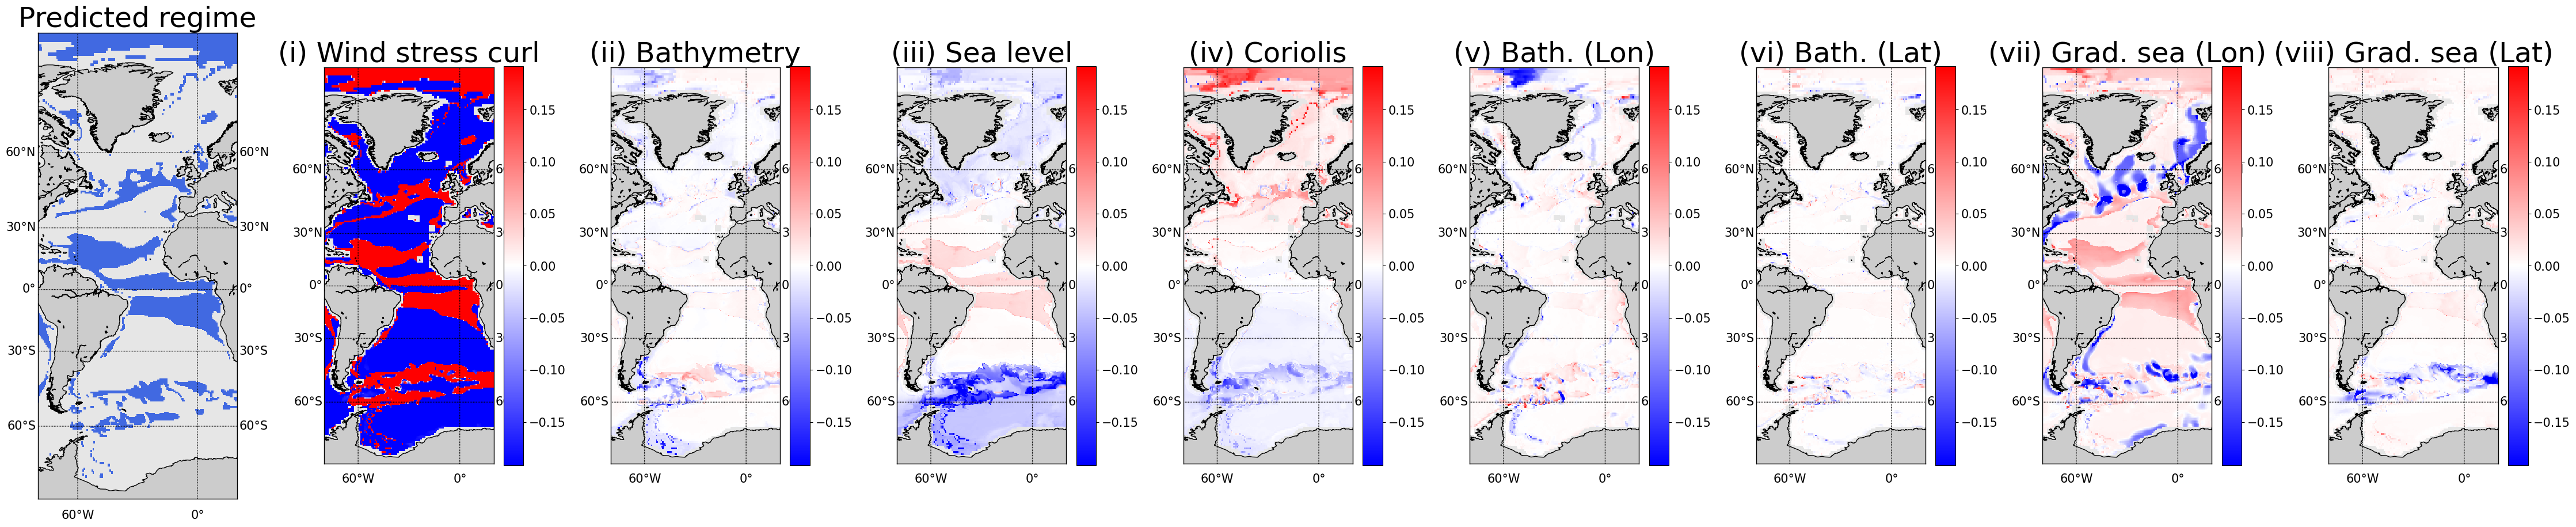

Regime 0


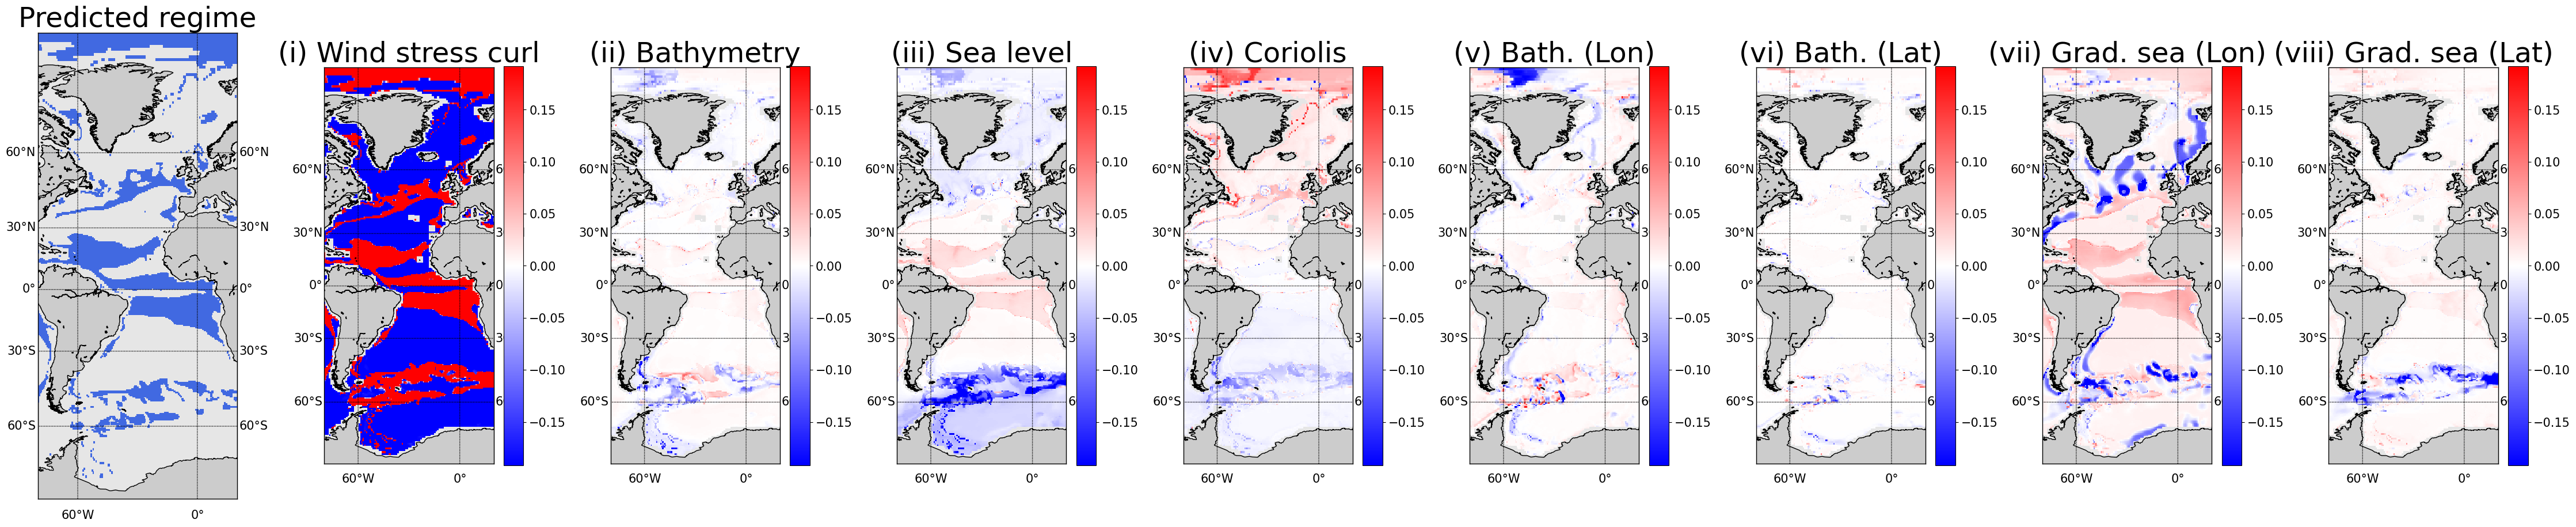

Regime 0


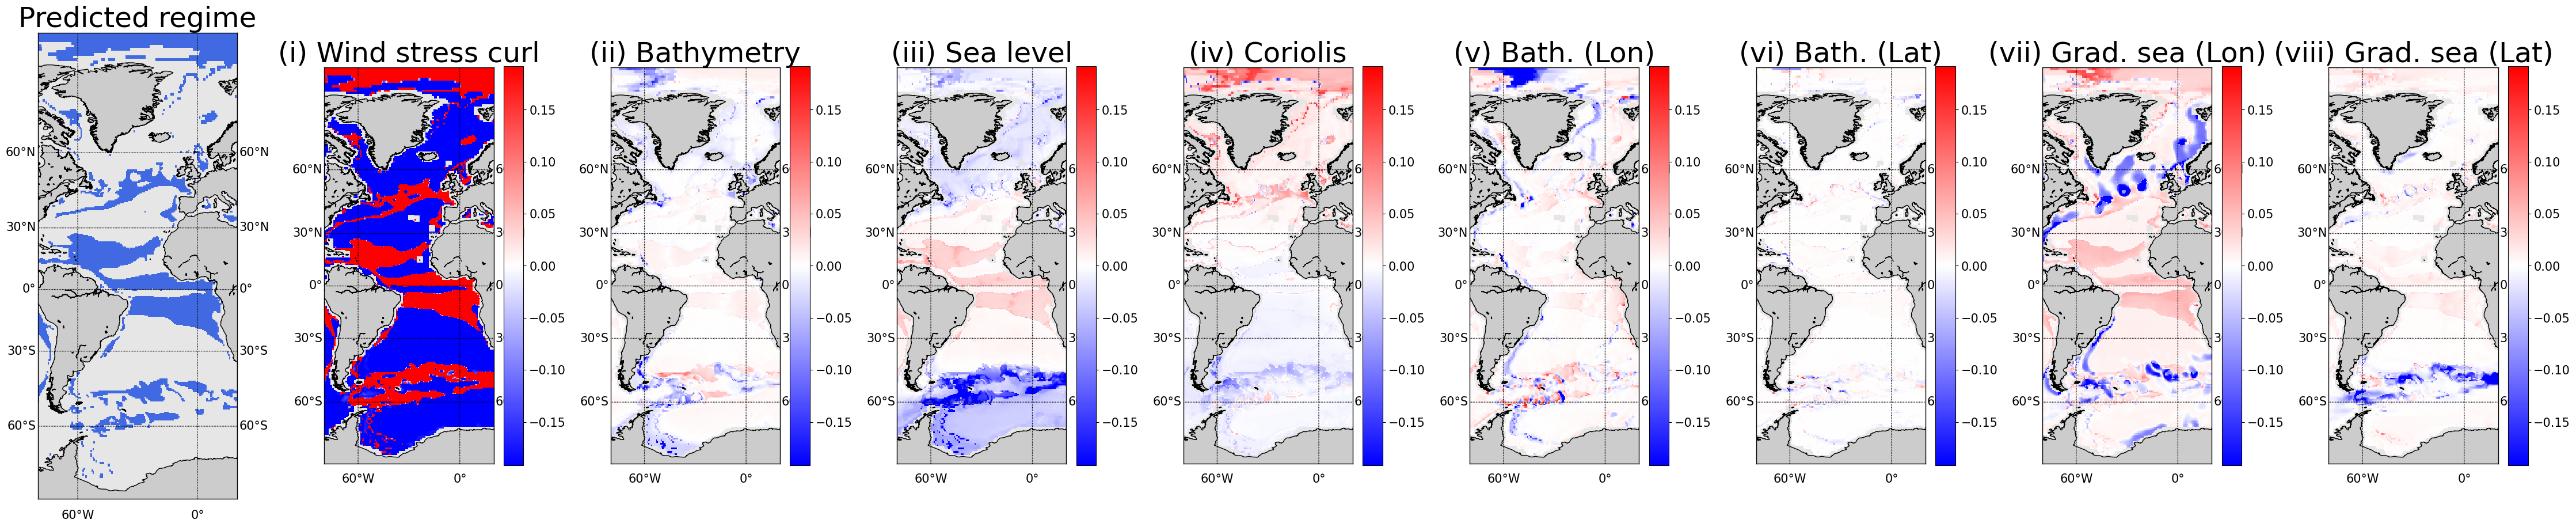

Regime 0


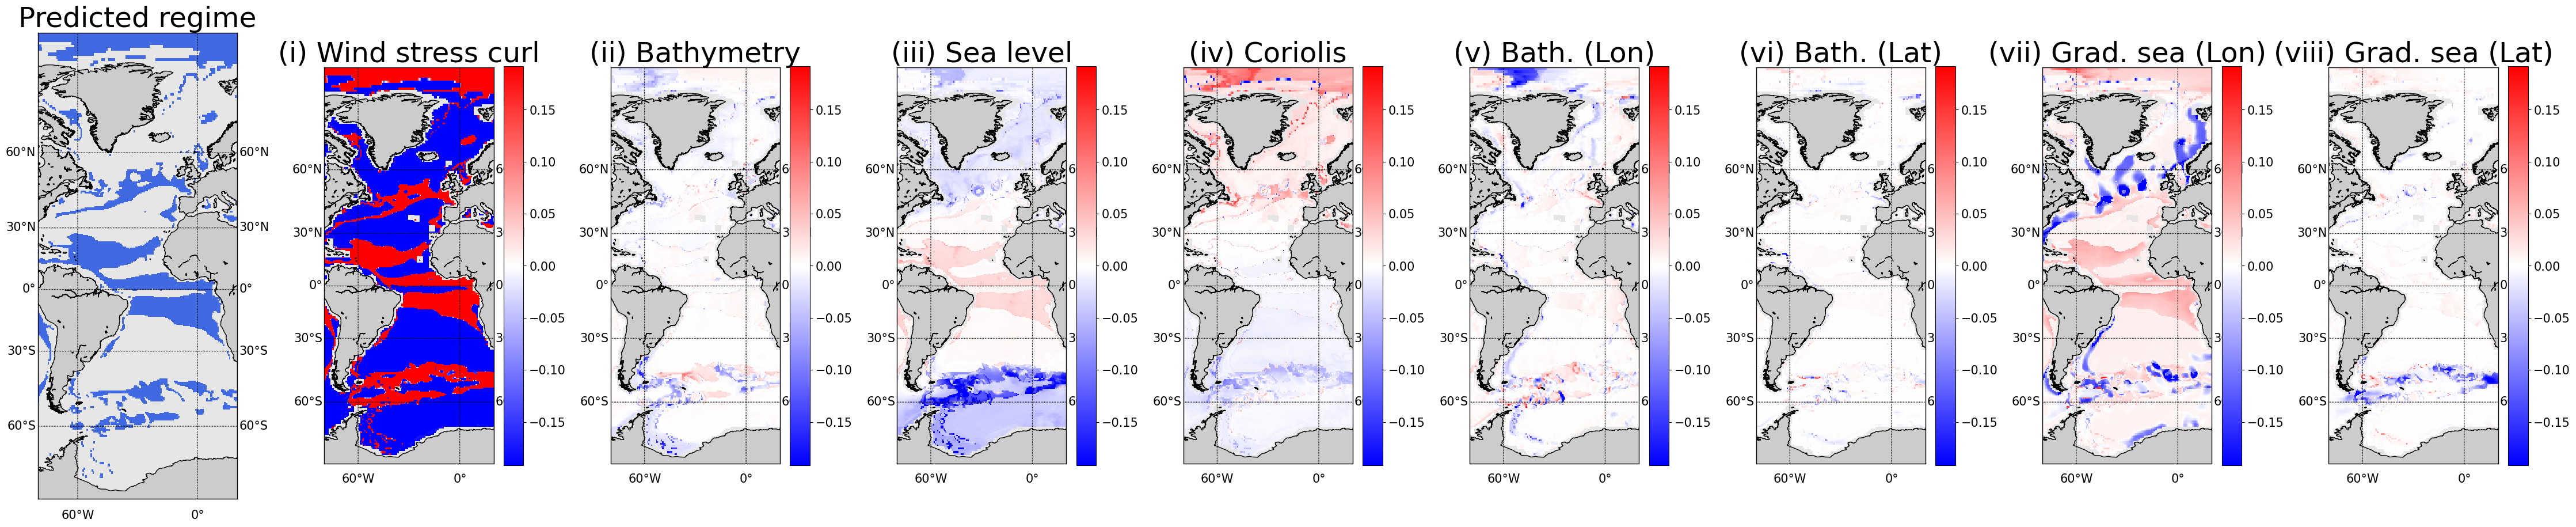

Regime 0


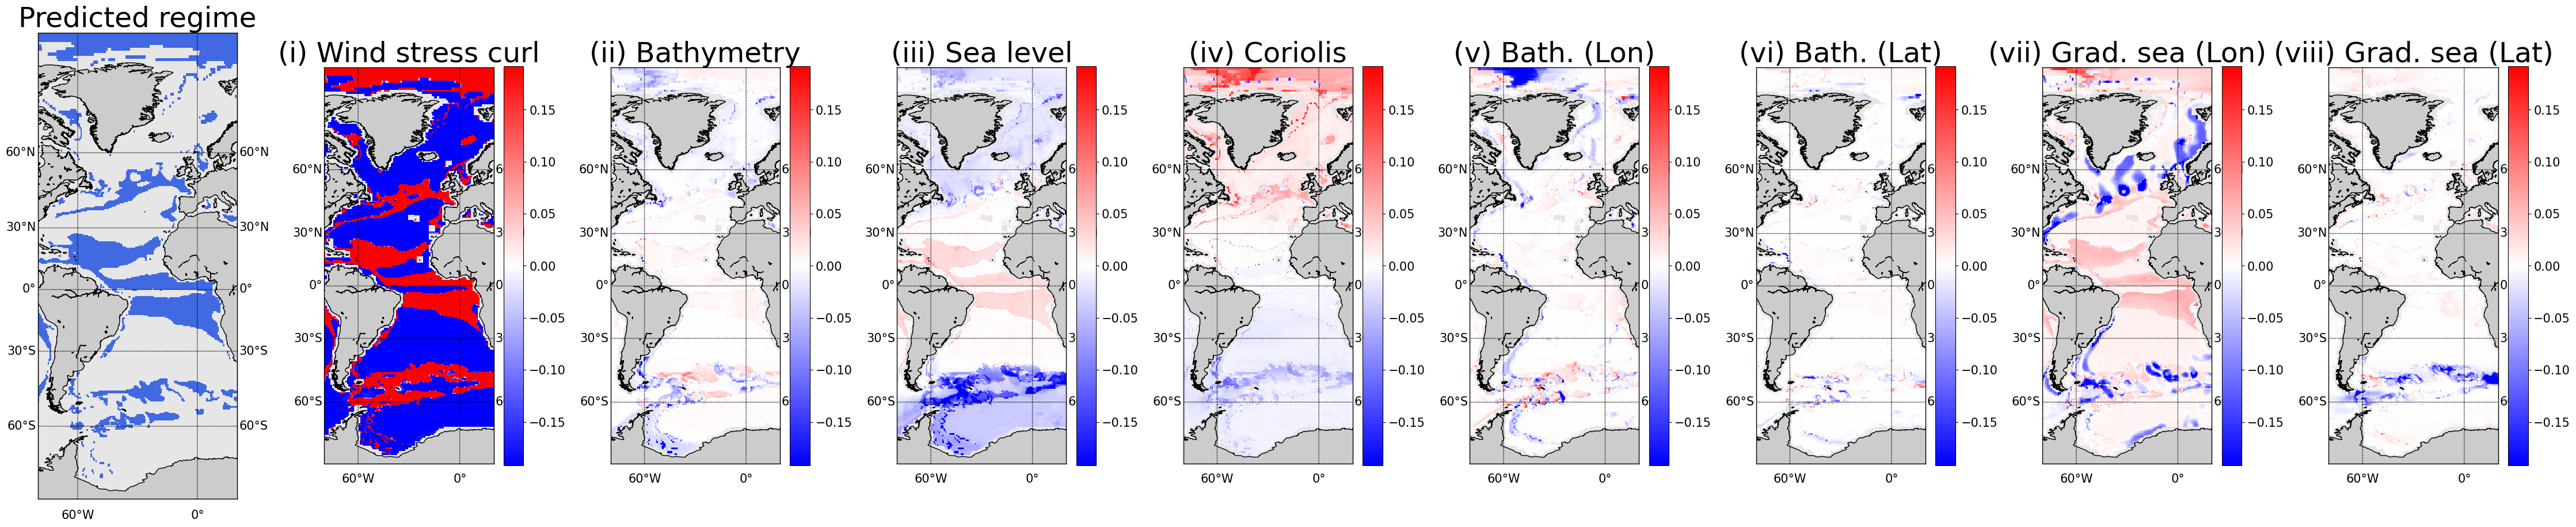

In [9]:

for i in range(shap_ens_values.shape[0]):
    #construct explainer for shap object
    exp = shap._explanation.Explanation(shap_ens_values[i], base_values = shap_base_values, 
                                        data = shap_data, feature_names= ['curlTau', 'SSH20mean', 'gradSSHx',
                                        'gradSSHy', 'bathm', 'gradBathm_x', 'gradBathm_y', 'F'])

    # You can try changing the regime_num to see how the shap values vary depending on the predicted regime
    plot_shap_by_group(regime_num=0, explainer=exp, clim = [-0.1915, 0.1915])
